# 通过Recap和BRICS对分子拆解与合成

## 1.Recap拆解
另一个与化学反应相关的功能是Recap，Recap可以模仿实验室中的正向合成过程来进行逆向操作，对分子进行一系列的转换与分解，最终得到一组合理的分子片段。Recap可以对拆解过程进行追踪，并形成类似树的数据结构。原始分子记为根节点（root），被拆解的分子记为父节点（parent），拆解得到的分子记为子节点(children)，某节点下的所有分支节点为子孙节点(all children)，某节点上的所有父节点为祖先节点（ultimate parents），无法继续拆解分子记为叶子节点(leaves)。所有英文翻译对应recap中的属性或方法名。

 - Recap算法拆解分子：Recap.RecapDecompose(mol)

In [1]:
from rdkit.Chem import Recap
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
m = Chem.MolFromSmiles('c1ccccc1OCCOC(=O)CC')
hierarch = Recap.RecapDecompose(m)

可以从节点对象通过函数获取其叶子节点、子孙节点，得到的都是字典，键为节点的smiles，值为节点对象。
 - 叶子节点函数：hierarch.GetLeaves()
 - 子孙节点函数：hierarch.GetAllChildren()
 - 祖先节点函数，返回列表：getUltimateParents()

In [2]:
print(hierarch.GetLeaves().keys())
print(hierarch.GetAllChildren().keys())
print(hierarch.getUltimateParents()[0].smiles)

dict_keys(['*C(=O)CC', '*CCO*', '*c1ccccc1', '*CCOc1ccccc1'])
dict_keys(['*C(=O)CC', '*OCCOc1ccccc1', '*CCO*', '*c1ccccc1', '*CCOC(=O)CC', '*CCOc1ccccc1'])
CCC(=O)OCCOc1ccccc1


还可以查看节点的如下属性：
 - smiles：smiles（字符串）
 - 子节点：children（字典）
 - 父节点：parents（字典）

In [3]:
child = hierarch.children['*OCCOc1ccccc1']
print(child.smiles)
print(child.children.keys())
print(child.parents.keys())

*OCCOc1ccccc1
dict_keys(['*CCO*', '*c1ccccc1'])
dict_keys(['CCC(=O)OCCOc1ccccc1'])


 - 查看下叶子节点的分子

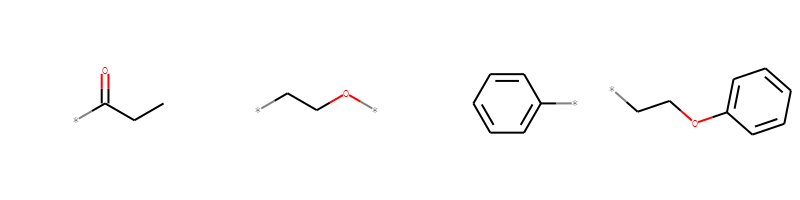

In [4]:
leaves = list(hierarch.GetLeaves().values())
img = Chem.Draw.MolsToGridImage([x.mol for x in leaves], molsPerRow=4, subImgSize=(200, 200))
img

In [5]:
img.save('data/recap_brics_1.png')

## 2.BRICS拆解
Rdkit中还有一种BRICS算法，同样可以用于拆解分子。与recap不同，该算法是根据键是否能够合成来进行拆解。该方法返回一个经过去重的列表，在原子上的序号对应一种特定的反应类型。

- BRICS算法拆解分子：BRICS.BRICSDecompose(m)

In [6]:
from rdkit.Chem import BRICS
m = Chem.MolFromSmiles('c1ccccc1OCCOC(=O)CC')
BRICS.BRICSDecompose(m)

{'[1*]C(=O)CC', '[16*]c1ccccc1', '[3*]O[3*]', '[4*]CC[4*]'}

 - 对一组分子生成片段

In [7]:
import os
from rdkit.Chem import RDConfig
cdk_file = os.path.join(RDConfig.RDDocsDir, 'Book\data\cdk2.sdf')
cdk2mols = Chem.SDMolSupplier(cdk_file)
allfrags = set()
for m in cdk2mols:
    pieces = BRICS.BRICSDecompose(m)
    allfrags.update(pieces)
print(len(allfrags))
print(sorted(allfrags)[:3])

90
['NS(=O)(=O)c1ccc(N/N=C2\\C(=O)Nc3ccc(Br)cc32)cc1', '[1*]C(=O)C(C)C', '[1*]C(=O)NN(C)C']


## 3.BRICS合成
 - BRICS模块除了支持拆解分子，也可以对一组片段进行合成：BRICS.BRICSBuild()
 - 返回一个生成器，可以通过next()来获取元素
 - 生成的分子也是未经过核对的，可以对分子重新计算一下隐式化合价、环相关等属性，并做更新：UpdatePropertyCache()

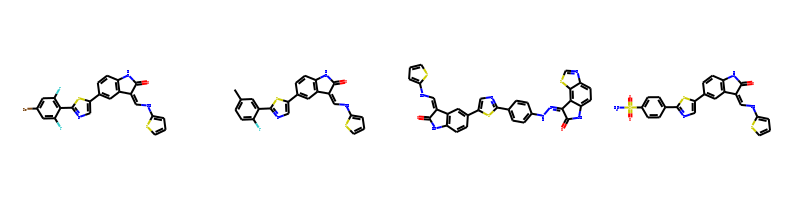

In [8]:
fragms = [Chem.MolFromSmiles(x) for x in sorted(allfrags)]
ms = BRICS.BRICSBuild(fragms)
prods = [next(ms) for x in range(4)]
[prod.UpdatePropertyCache(strict=False) for prod in prods]
img = Chem.Draw.MolsToGridImage(prods, molsPerRow=4, subImgSize=(200, 200))
img

In [9]:
img.save('data/recap_brics_2.png')

可以通过设置随机种子或设置scrambleReagents参数来保证可重复性
 - 在BRICSBuild执行前设置随机种子

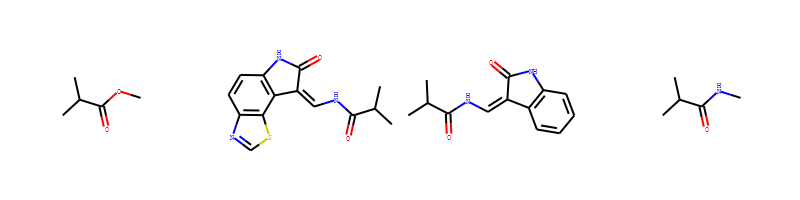

In [10]:
import random
random.seed(100)
fragms = [Chem.MolFromSmiles(x) for x in sorted(allfrags)]
ms = BRICS.BRICSBuild(fragms)
prods = [next(ms) for x in range(4)]
[prod.UpdatePropertyCache(strict=False) for prod in prods]
img = Chem.Draw.MolsToGridImage(prods, molsPerRow=4, subImgSize=(200, 200))
img

In [11]:
img.save('data/recap_brics_3.png')

 - 设置scrambleReagents参数

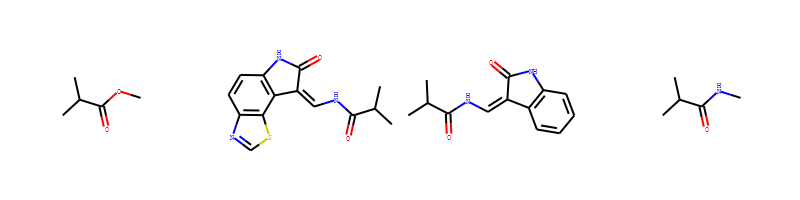

In [12]:
fragms = [Chem.MolFromSmiles(x) for x in sorted(allfrags)]
ms = BRICS.BRICSBuild(fragms, scrambleReagents=False)
prods = [next(ms) for x in range(4)]
[prod.UpdatePropertyCache(strict=False) for prod in prods]
Chem.Draw.MolsToGridImage(prods, molsPerRow=4, subImgSize=(200, 200))